In [1]:
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset_handler import create_dataset, remove_rare_chars
DATASET_DIR = r'../../Dataset/trdg'
LABELS_PATH = r'../../Dataset/trdg/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATASET_DIR, LABELS_PATH, sim2tra=False)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=3)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs)

Number of images found: 3702
Number of labels found: 3702
Number of unique characters: 1885
Characters present: {'㐌': 387, '浪': 359, '朱': 296, '\U000f070b': 292, '𠊛': 262, '\U000f047c': 260, '尼': 256, '娘': 252, '𦋦': 248, '𢚸': 246, '吏': 236, '固': 231, '拱': 220, '之': 199, '埃': 195, '情': 194, '𠳒': 179, '買': 178, '群': 175, '芇': 173, '𠓨': 157, '欺': 154, '別': 149, '麻': 148, '花': 147, '𠬠': 146, '𧗱': 144, '爫': 143, '仙': 142, '𡗶': 138, '𠄩': 132, '塘': 129, '如': 127, '𦖑': 126, '浽': 123, '𠫾': 122, '命': 122, '時': 121, '渚': 120, '渃': 118, '饒': 116, '呐': 115, '払': 115, '強': 114, '分': 114, '傷': 109, '𡢐': 108, '些': 108, '冲': 107, '鐄': 106, '𫽄': 106, '𢬣': 104, '低': 104, '生': 102, '皮': 100, '於': 100, '𧡊': 99, '仍': 99, '身': 98, '咍': 98, '茹': 97, '庒': 95, '牢': 94, '𣈜': 94, '昆': 93, '調': 92, '沛': 89, '\U000f061a': 89, '緣': 88, '細': 87, '公': 86, '月': 85, '油': 84, '﨤': 84, '戈': 84, '典': 84, '爲': 83, '排': 81, '畧': 80, '催': 78, '㗂': 77, '包': 76, '碎': 75, '𠁀': 75, '\U000f02c7': 74, '貝': 70, '賒': 70, '𢪀': 69, '共'

## Visualize the data

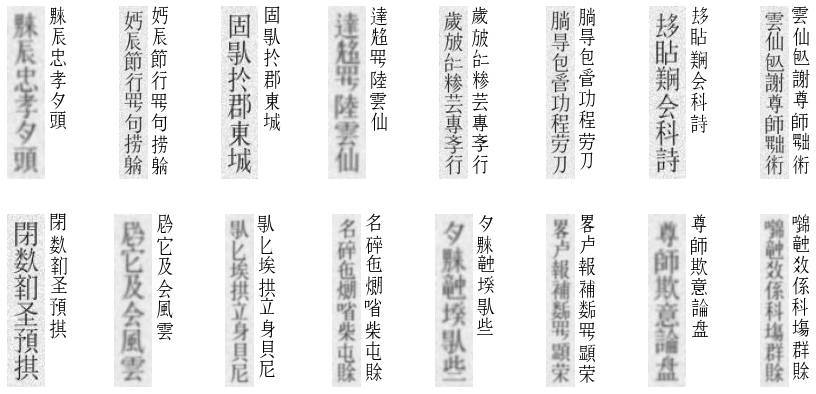

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from cnn import custom_cnn, get_imagenet_model, reshape_for_cnn
from ctc import CTCLayer

In [9]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')
    
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing the output to the RNN
    x = reshape_for_cnn(x, dim_to_keep=-1)

    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.4,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    return model

In [10]:
## Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_model.summary(line_length=100)

In [11]:
# imagenet_output_layer = 'block4_pool'
# model = build_crnn(imagenet_model, imagenet_output_layer)
model = build_crnn()
model.summary(line_length=100)

Model: "CRNN"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                             

# Training

In [12]:
from dataset_handler import process_one_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Data input pipeline

In [13]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = process_one_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [14]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Callbacks

In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    min_lr = 1e-7, # Lower bound on the learning rate 
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Cross validation with K-Fold

In [16]:
from kfold import kfold_decorator
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 2e-4
EPOCHS = 100

In [17]:
@kfold_decorator(n_splits=10, random_state=2022)
def train(model, img_paths, labels, train_idx=None, valid_idx=None):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE))
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH)
    
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = EPOCHS,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    return (
        valid_tf_dataset, 
        early_stopping_callback.best_epoch, 
        edit_distance_callback.logs,
        history,
    )

In [18]:
%%time
valid_datasets, best_epochs, edist_logs, histories, models = train(model, img_paths, labels)

============== Fold 01 training ==============
Epoch 1/100
209/209 [==============================] - 16s 45ms/step - loss: 50.6703 - val_loss: 53.5372 - lr: 2.0000e-04
Epoch 2/100
209/209 [==============================] - 7s 32ms/step - loss: 44.2001 - val_loss: 46.3683 - lr: 2.0000e-04
Epoch 3/100
209/209 [==============================] - 7s 33ms/step - loss: 36.0691 - val_loss: 32.8665 - lr: 2.0000e-04
Epoch 4/100
209/209 [==============================] - 7s 32ms/step - loss: 20.4234 - val_loss: 18.0441 - lr: 2.0000e-04
Epoch 5/100
209/209 [==============================] - 7s 32ms/step - loss: 10.7364 - val_loss: 12.1999 - lr: 2.0000e-04
Epoch 6/100
209/209 [==============================] - 7s 33ms/step - loss: 5.8660 - val_loss: 8.9587 - lr: 2.0000e-04
Epoch 7/100
209/209 [==============================] - 7s 33ms/step - loss: 3.3069 - val_loss: 6.8451 - lr: 2.0000e-04
Epoch 8/100
209/209 [==============================] - 7s 33ms/step - loss: 1.9272 - val_loss: 6.8959 - lr: 2

 - Mean edit distance: 1.4140625
209/209 [==============================] - 7s 32ms/step - loss: 0.0209 - val_loss: 2.2240 - lr: 5.0000e-05
Epoch 38/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0200 - val_loss: 2.2051 - lr: 2.5000e-05
Epoch 39/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0192 - val_loss: 2.1956 - lr: 2.5000e-05
Epoch 40/100
209/209 [==============================] - 7s 33ms/step - loss: 0.0189 - val_loss: 2.1919 - lr: 2.5000e-05
Epoch 41/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0184 - val_loss: 2.2002 - lr: 2.5000e-05
Epoch 42/100
207/209 [============================>.] - ETA: 0s - loss: 0.0177
Epoch 42: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
 - Mean edit distance: 1.4010416
209/209 [==============================] - 7s 32ms/step - loss: 0.0177 - val_loss: 2.1944 - lr: 2.5000e-05
Epoch 43/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0174 

Epoch 14/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1530 - val_loss: 2.6751 - lr: 2.0000e-04
Epoch 15/100
209/209 [==============================] - 7s 32ms/step - loss: 0.1220 - val_loss: 2.6445 - lr: 2.0000e-04
Epoch 16/100
209/209 [==============================] - 7s 32ms/step - loss: 0.1001 - val_loss: 2.5191 - lr: 2.0000e-04
Epoch 17/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0839 - val_loss: 2.5485 - lr: 2.0000e-04
Epoch 18/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0702 - val_loss: 2.5035 - lr: 2.0000e-04
Epoch 19/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0600 - val_loss: 2.4363 - lr: 2.0000e-04
Epoch 20/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0520 - val_loss: 2.4285 - lr: 2.0000e-04
Epoch 21/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0451 - val_loss: 2.3510 - lr: 2.0000e-04
Epoch 22/100
209/209 [==================

209/209 [==============================] - 7s 33ms/step - loss: 0.0104 - val_loss: 1.7339 - lr: 1.2500e-05
Early stopping and restored the model weights from the end of epoch 45 - loss: 1.705085277557373

============== Fold 04 training ==============
Epoch 1/100
209/209 [==============================] - 13s 42ms/step - loss: 50.4965 - val_loss: 52.1745 - lr: 2.0000e-04
Epoch 2/100
209/209 [==============================] - 7s 34ms/step - loss: 43.6635 - val_loss: 44.2759 - lr: 2.0000e-04
Epoch 3/100
209/209 [==============================] - 7s 32ms/step - loss: 33.9035 - val_loss: 26.0648 - lr: 2.0000e-04
Epoch 4/100
209/209 [==============================] - 7s 33ms/step - loss: 18.0102 - val_loss: 15.6242 - lr: 2.0000e-04
Epoch 5/100
209/209 [==============================] - 7s 33ms/step - loss: 9.5296 - val_loss: 10.3051 - lr: 2.0000e-04
Epoch 6/100
209/209 [==============================] - 7s 33ms/step - loss: 5.3157 - val_loss: 8.7177 - lr: 2.0000e-04
Epoch 7/100
209/209 [===

Epoch 36/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0269 - val_loss: 2.2954 - lr: 1.2500e-05
Epoch 37/100
207/209 [============================>.] - ETA: 0s - loss: 0.0262
Epoch 37: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
 - Mean edit distance: 1.4192709
209/209 [==============================] - 7s 32ms/step - loss: 0.0261 - val_loss: 2.3031 - lr: 1.2500e-05
Epoch 38/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0261 - val_loss: 2.2864 - lr: 6.2500e-06
Epoch 39/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0253 - val_loss: 2.2871 - lr: 6.2500e-06
Epoch 40/100
207/209 [============================>.] - ETA: 0s - loss: 0.0249
Epoch 40: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
 - Mean edit distance: 1.4010416
209/209 [==============================] - 7s 32ms/step - loss: 0.0249 - val_loss: 2.2908 - lr: 6.2500e-06
Epoch 41/100
209/209 [============================

209/209 [==============================] - 7s 32ms/step - loss: 0.2942 - val_loss: 6.4373 - lr: 2.0000e-04
Epoch 17/100
209/209 [==============================] - 7s 33ms/step - loss: 0.3355 - val_loss: 9.6539 - lr: 2.0000e-04
Epoch 18/100
207/209 [============================>.] - ETA: 0s - loss: 0.3614
Epoch 18: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 2.5546875
209/209 [==============================] - 7s 34ms/step - loss: 0.3608 - val_loss: 7.5809 - lr: 2.0000e-04
Epoch 19/100
209/209 [==============================] - 7s 33ms/step - loss: 0.2207 - val_loss: 5.7838 - lr: 1.0000e-04
Epoch 20/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1386 - val_loss: 5.2855 - lr: 1.0000e-04
Epoch 21/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1147 - val_loss: 5.2350 - lr: 1.0000e-04
Epoch 22/100
209/209 [==============================] - 7s 32ms/step - loss: 0.0979 - val_loss: 5.2355 - lr: 1.0000e-

Epoch 12/100
209/209 [==============================] - 7s 31ms/step - loss: 0.4777 - val_loss: 4.7628 - lr: 2.0000e-04
Epoch 13/100
208/209 [============================>.] - ETA: 0s - loss: 0.3578
Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
 - Mean edit distance: 2.0729167
209/209 [==============================] - 7s 32ms/step - loss: 0.3579 - val_loss: 4.8150 - lr: 2.0000e-04
Epoch 14/100
209/209 [==============================] - 7s 33ms/step - loss: 0.3225 - val_loss: 3.7826 - lr: 1.0000e-04
Epoch 15/100
209/209 [==============================] - 7s 33ms/step - loss: 0.2076 - val_loss: 3.7194 - lr: 1.0000e-04
Epoch 16/100
209/209 [==============================] - 7s 32ms/step - loss: 0.1734 - val_loss: 3.5668 - lr: 1.0000e-04
Epoch 17/100
209/209 [==============================] - 7s 32ms/step - loss: 0.1508 - val_loss: 3.4400 - lr: 1.0000e-04
Epoch 18/100
209/209 [==============================] - 7s 33ms/step - loss: 0.1352 - val_loss: 3.4381 -

Epoch 2/100
209/209 [==============================] - 7s 32ms/step - loss: 44.0563 - val_loss: 46.6394 - lr: 2.0000e-04
Epoch 3/100
209/209 [==============================] - 7s 32ms/step - loss: 38.6351 - val_loss: 47.5166 - lr: 2.0000e-04
Epoch 4/100
209/209 [==============================] - 7s 32ms/step - loss: 32.0255 - val_loss: 36.3018 - lr: 2.0000e-04
Epoch 5/100
209/209 [==============================] - 7s 33ms/step - loss: 25.6936 - val_loss: 32.0436 - lr: 2.0000e-04
Epoch 6/100
209/209 [==============================] - 7s 32ms/step - loss: 20.3174 - val_loss: 30.1670 - lr: 2.0000e-04
Epoch 7/100
209/209 [==============================] - 7s 33ms/step - loss: 15.8250 - val_loss: 24.9571 - lr: 2.0000e-04
Epoch 8/100
209/209 [==============================] - 7s 33ms/step - loss: 12.3696 - val_loss: 24.0884 - lr: 2.0000e-04
Epoch 9/100
209/209 [==============================] - 7s 33ms/step - loss: 9.5609 - val_loss: 23.5991 - lr: 2.0000e-04
Epoch 10/100
209/209 [===========

## Get the best CRNN model and its results

In [19]:
from kfold import get_best_fold
from visualizer import plot_training_results
(
    best_valid_dataset, 
    best_fold_epoch,
    best_edist_log, 
    best_history,
    best_model,
    best_fold_idx, 
    best_loss
) = get_best_fold(valid_datasets, best_epochs, edist_logs, histories, models)

Fold 01 - Mean edit distance: 1.3984375
24/24 [==============================] - 0s 14ms/step - loss: 2.1749
Fold 02 - Mean edit distance: 6.970485687255859
24/24 [==============================] - 0s 14ms/step - loss: 31.9141
Fold 03 - Mean edit distance: 1.2786458730697632
24/24 [==============================] - 0s 14ms/step - loss: 1.7051
Fold 04 - Mean edit distance: 1.4088541269302368
24/24 [==============================] - 0s 13ms/step - loss: 2.2864
Fold 05 - Mean edit distance: 5.7734375
24/24 [==============================] - 0s 14ms/step - loss: 25.7256
Fold 06 - Mean edit distance: 1.8984375
24/24 [==============================] - 0s 14ms/step - loss: 5.0491
Fold 07 - Mean edit distance: 1.609375
24/24 [==============================] - 0s 13ms/step - loss: 2.9672
Fold 08 - Mean edit distance: 5.825520992279053
24/24 [==============================] - 0s 13ms/step - loss: 24.9571
Fold 09 - Mean edit distance: 6.450520992279053
24/24 [==============================] - 0s 

Fold 03 has the best result at epoch 45:
- Loss on validation: 1.705085277557373
- Mean edit distance: 1.2786458730697632


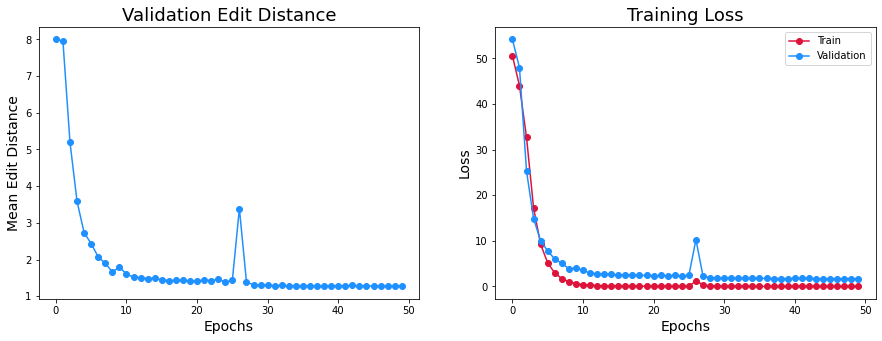

In [34]:
print(f'Fold {best_fold_idx + 1:02d} has the best result at epoch {best_fold_epoch + 1}:')
print(f'- Loss on validation: {best_loss}')
print(f'- Mean edit distance: {best_edist_log[best_fold_epoch]}')
plot_training_results(best_history, best_edist_log, 'CRNN.png')
best_model.save('CRNN.h5')

# Inference

In [35]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

## Reload the model

In [36]:
reloaded_model = load_model('CRNN.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_3"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

## On test dataset

Batch 1: ['𠊛匕埃拱立身貝尼', '𡄎𥪝𢼂係科塲群賖', '沛朱𠬠法底防𫉚身', '𠓨䜹朱訢事情', '丕𡢐𠦳淡登程買安', '昆渚拮挭群\U000f0021𭛣之', '因机謀事𠴍浪', '雲仙倍且謝恩', '仙浪各注拱昆', '崔匕渚呵呐𥹰', '\U000f0778咍𠸜户\U000f047c之', '爫恩呵易徐𠊛者恩', '埃咍飭𡛔才髙幅尼', '㐌毛麻吏添咍', '傕匕㛪唉金連', '月娥踈𭛣前程']

Batch 2: ['曰書戈妬𨑮払鄧低', '後塘昆呵暫𨆢', '䀡𦝄耒吏想情故人', '箕尼庙宇𧵆低', '共饒排户𠸜耒', '\U000f084e嗔㐌産固𦀊絲紅', '云仙暫住𠬠囬𢭂书', '呵𠸦户陸福䝨生昆', '湿高買別所才', '丕𡢐客竹伴枚買牟', '直浪嗔讓仙\U000f0268爫英', '䏾𦝄𣃣格梗橷', '移蹎𣃣課平明', '塘賖𠦳淡嗔迻𠬠𢈱', '管包𡮇分𦟐紅', '𬂙澄京地㐌候細尼']

Batch 3: ['調排𠸜户𠬠欺買詳', '舘浪唭几不才𠁀𠸗', '太公𠸗𠬠勤鈎', '滝溇\U000f0829𣷮請台', '哙𦋦買別母慈𧗱圭', '迻𠀧\U000f0629茦底防𫉚身', '仙浪𠹾𥙩恩朱', '隐身蹺准安閒', '𢧚庒𡮇分之麻', '芇咍分泊如𪿙\U000f086b尼', '童浪𡗶坦固咍', '吏通八陣奇方', '㐌通天地吏咍𭛣𠁀', '感𠸜歳𧘇路程莫之', '𠬠交𠄩册麻𠀧爻重', '吹𢧚芒病声灵']



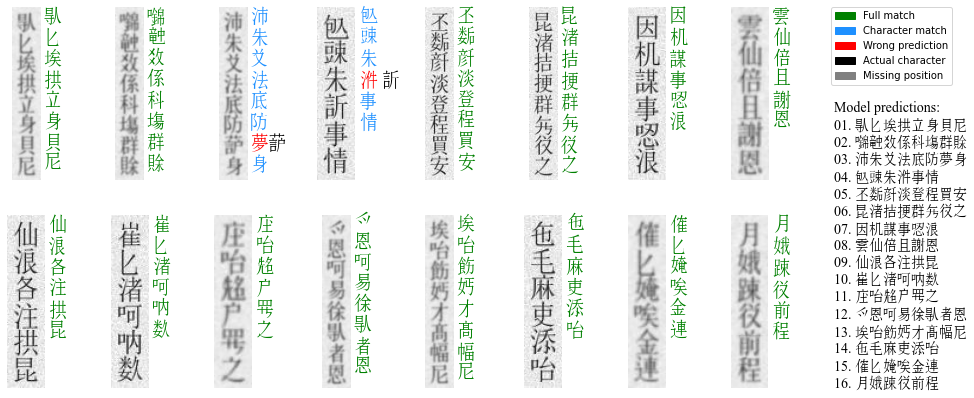

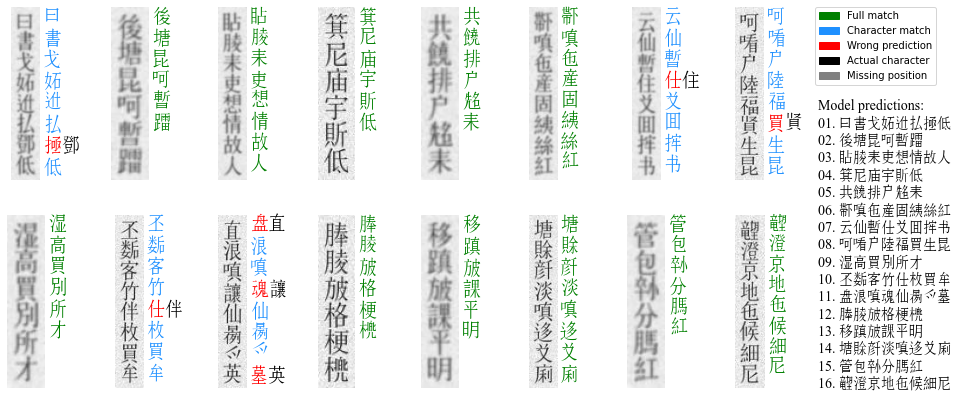

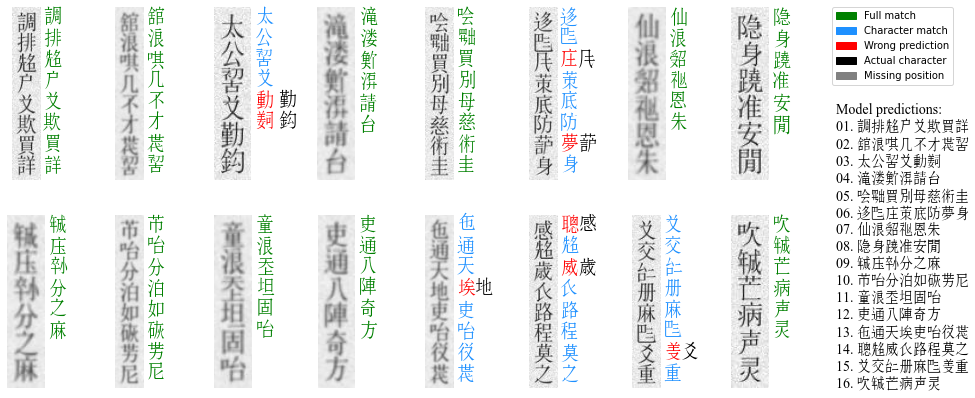

In [37]:
valid_dataset, valid_idxs = best_valid_dataset
for idx, batch in enumerate(valid_dataset.take(3)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels_in_batch = []
    
    for label in batch['label']:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        labels_in_batch.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch['image'])
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[idxs_in_batch], 
        labels = labels_in_batch, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {labels_in_batch}\n')

## On random image

In [38]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)

Predicted text: 大越史記全書


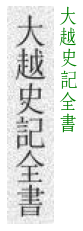

In [39]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))